In [1]:
!pip install filterpy
#!pip install ipywidgets


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import json
from numpy.random import randn
from scipy.integrate import quad
from scipy.optimize import minimize
#import ipywidgets
#import matplotlib as mpl
#import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
#from matplotlib.patches import Circle
from filterpy.kalman import EnsembleKalmanFilter as EnKF
from filterpy.common import Q_discrete_white_noise

In [3]:
# Set a seed for reproducibility
seed_value = 41
np.random.seed(seed_value)

# Assumed dynamics
$
\begin{cases}
u_\epsilon(t,\frac{t}{\epsilon}) \approx u_0(t)-\epsilon\frac{sin(2\pi\frac{t}{\epsilon})}{2\pi}\\
u_0(t)=1
\end{cases}
$

# Scale transition
$\Phi(t,u_{0,k},\Gamma) = wu_{0,k}(t)+(1-w)\Gamma-\epsilon\frac{sin(2\pi\frac{t}{\epsilon})}{2\pi}$

# Assimilation parameters
$\begin{cases}
H(x) = x\\
M(x) = x\\
R = 0.01\\
Q = 0.001\\
P=0.1\\
N=20
\end{cases}$


# EnKF

## Intialization

In [4]:
eps=1/360
h=15
step=0.001
#In minutes
macrostep=30
#In seconds
microstep=1

In [5]:
def hx(x):
    return np.array([x[0]])

def fx(x, dt):
    return F @ x
    
F = np.array([[1., 0.],[0., 1.]])

x = np.array([1., 1.])
P = np.eye(2) * 0.1
enf = EnKF(x=x, P=P, dim_z=1, dt=1., N=20, hx=hx, fx=fx)
std_noise = 10.
enf.R *= 0.01
enf.Q = Q_discrete_white_noise(2, 0.001, .001)

## Operators

In [6]:
#microscopic operator
def Oe(X,A,w,k):
    return w*X + (1-w)*A - eps*np.sin(2*np.pi*((1+k)*30*60)/eps)/(2*np.pi)
#helper function to get estimated microscopic values between 30min-30min+10s
def Xe_Forecast(X,A,w,k,microstep):
    return np.array([Oe(np.mean(X),A,w,k+step*i) for i in range(int(microstep/step))])

## plotting

In [7]:
_default_size = (9, 4)
def plot_measurements(xs, ys=None, dt=None, color='k', lw=1, label='Measurements',
                      lines=False, **kwargs):
    
    if ys is None and dt is not None:
        ys = xs
        xs = np.arange(0, len(ys)*dt, dt)

    plt.autoscale(tight=False)
    if lines:
        if ys is not None:
            return plt.plot(xs, ys, color=color, lw=lw, ls='--', label=label, **kwargs)
        else:
            return plt.plot(xs, color=color, lw=lw, ls='--', label=label, **kwargs)
    else:
        if ys is not None:
            return plt.scatter(xs, ys, edgecolor=color, facecolor='none',
                        lw=2, label=label, **kwargs),
        else:
            return plt.scatter(range(len(xs)), xs, edgecolor=color, facecolor='none',
                        lw=2, label=label, **kwargs),

## Measurements

In [8]:
file_path1 = 'GenData/True/Data_Model1'  # Replace 'your_file.json' with the actual file path
file_path2 = 'GenData/True/Data_Model2'
file_path3 = 'GenData/True/Data_Model3'
file_path4 = 'GenData/True/Data_Model4'

with open(file_path1, 'r') as file1:
    data1 = json.load(file1)
with open(file_path2, 'r') as file2:
    data2 = json.load(file2) 
with open(file_path3, 'r') as file3:
    data3 = json.load(file3)
with open(file_path4, 'r') as file4:
    data4 = json.load(file4)

Y01True = [x[0] for x in data1]
Y02True = [x[0] for x in data2]
Y03True = [x[0] for x in data3]
Y04True = [x[0] for x in data4]



file_path1 = 'GenData/Noised/Data_Model1'  # Replace 'your_file.json' with the actual file path
file_path2 = 'GenData/Noised/Data_Model2'
file_path3 = 'GenData/Noised/Data_Model3'
file_path4 = 'GenData/Noised/Data_Model4'

with open(file_path1, 'r') as file1:
    data1 = json.load(file1)
with open(file_path2, 'r') as file2:
    data2 = json.load(file2) 
with open(file_path3, 'r') as file3:
    data3 = json.load(file3)
with open(file_path4, 'r') as file4:
    data4 = json.load(file4)

Y01 = [x[0] for x in data1]
Ye1 = [x[1] for x in data1]
Y02 = [x[0] for x in data2]
Ye2 = [x[1] for x in data2]
Y03 = [x[0] for x in data3]
Ye3 = [x[1] for x in data3]
Y04 = [x[0] for x in data4]
Ye4 = [x[1] for x in data4]

In [9]:
def plotError(labl,SSE1,SSE2,SSE3,SSE4,title):
    # Generate x values from 0 to 30
    x = np.linspace(0, 29, 29)  # Adjust the third parameter to control the number of points

    # Plot the data
    plt.plot(x, SSE1, label=labl+'1')
    plt.plot(x, SSE2, label=labl+'2')
    plt.plot(x, SSE3, label=labl+'3')
    plt.plot(x, SSE4, label=labl+'4')

    # Add labels and title
    plt.xlabel('time (30min)')
    plt.ylabel('SSE')
    plt.title(title)

    # Add a legend
    plt.legend()
    plt.savefig('Plots/'+title+'.png')
    # Show the plot
    plt.show()

In [10]:
def assimilate(Y0,Ye,Ytrue0):
    results = []
    ps = []
    zs = []
    for t in range (0,29):
        # create measurement = t plus white noise
        z = Y0[t]
        zs.append(z)
        enf.predict()
        enf.update(np.asarray([z]))
        # save data
        results.append(enf.x[0])
        ps.append(3*(enf.P[0,0]**.5))

    results = np.asarray(results)
    
    ps = np.asarray(ps)
    #true=np.array([Ytrue0(i*30*60) for i in range(1,31) ])
    true=np.array(Ytrue0)
    SSEMacro=[]
    SSEMicro=[]
    for k in range(0,29):
    #microscopic measurements at k
        micro_measurements = np.array([i for i in Ye[k]])
        micro_measurements = micro_measurements[:int(microstep/step)]
        SSEMacro.append(np.sqrt(np.sum(np.square((true[k] - results[k])/true[k]))))
        SSEMicro.append(np.sqrt(np.sum(np.square((micro_measurements - Xe_Forecast(results[k],0,1,k,microstep))/micro_measurements))))

    #print("MSEMacro ",np.mean(np.array(SSEMacro)),"MSEMicro ",np.mean(np.array(SSEMicro)))
    return [SSEMacro,SSEMicro,true,results,micro_measurements,Xe_Forecast(results[k],0,1,k,microstep)]
    

In [11]:
def assimilate_minimize(Y0,Ye,Ytrue0):

    results = []
    ps = []
    zs = []

    initial_A=0.5 #Ye = Oe(wYa+(1-w)A) with w=0.5
    optimal_A=0
    
    for t in range (0,29):
        # create measurement = t plus white noise
        z = Y0[t]
        micro_measurements = np.array([i for i in Ye[t]])
        micro_measurements = micro_measurements[:int(microstep/step)]
        zs.append(z)

        #Assimilation
        enf.predict()
        enf.update(np.asarray([z]))

        #Minimization
        opt=minimize(lambda A: np.sum(np.square((micro_measurements - Xe_Forecast(enf.x[0],A,1/2,t,microstep)))),initial_A) 
        optimal_A=opt.x[0]
        
        # save data
        enf.x[0] = 0.5*enf.x[0] +0.5*optimal_A
        results.append(enf.x[0])
        ps.append(3*(enf.P[0,0]**.5))

    results = np.asarray(results)
    ps = np.asarray(ps)
    #true=np.array([Ytrue0(i*30*60) for i in range(1,31) ])
    true=np.array(Ytrue0)

    SSEMacro=[]
    SSEMicro=[]
    for k in range(0,29):
    #microscopic measurements at k   
        micro_measurements = np.array([i for i in Ye[k]]) 
        micro_measurements = micro_measurements[:int(microstep/step)]
        SSEMacro.append(np.sqrt(np.sum(np.square((true[k] - results[k])/true[k]))))
        SSEMicro.append(np.sqrt(np.sum(np.square((micro_measurements - Xe_Forecast(results[k],0,1,k,microstep))/micro_measurements))))
    #print("MSEMacro ",np.mean(np.array(SSEMacro)),"MSEMicro ",np.mean(np.array(SSEMicro)))
    return [SSEMacro,SSEMicro,true,results,micro_measurements,Xe_Forecast(results[k],0,1,k,microstep)]
    

In [12]:
def plotAssimilated(x0,xf,n,xlab,title,y1,y1lab,y2,y2lab):
    x = np.linspace(x0, xf, n)  # Adjust the third parameter to control the number of points

    # Plot the data
    plt.plot(x, y1, label=y1lab)
    plt.plot(x, y2, label=y2lab)

    # Add labels and title
    plt.xlabel(xlab)
    plt.ylabel('values')
    plt.title(title)

    # Add a legend
    plt.legend()
    plt.savefig('Plots/'+title+'.png')
    # Show the plot
    plt.show()

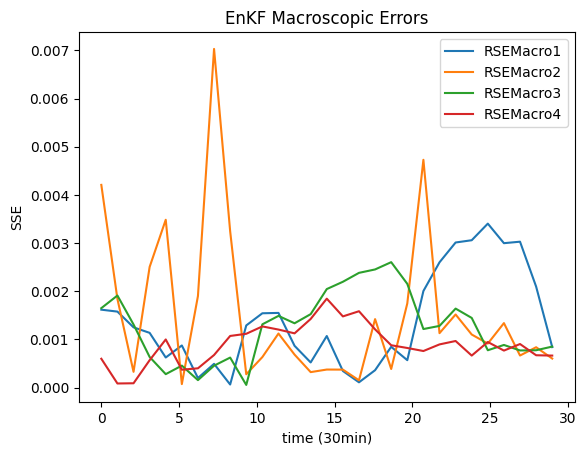

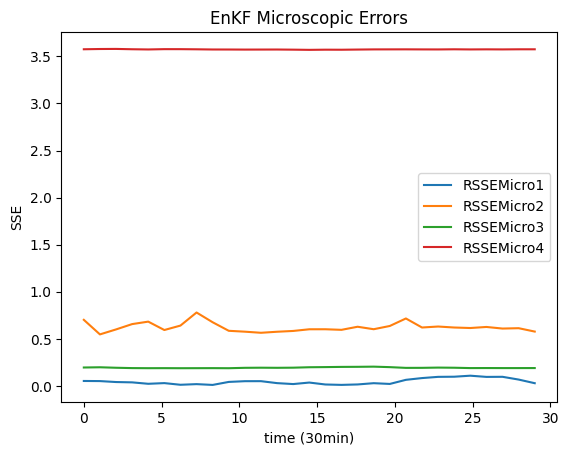

In [13]:
SSEMacro2,SSEMicro2,trueMacro2,assimilatedMacro2,lastTrueMicro2,lastAssimilatedMicro2=assimilate(Y02,Ye2,Y02True)
SSEMacro1,SSEMicro1,trueMacro1,assimilatedMacro1,lastTrueMicro1,lastAssimilatedMicro1=assimilate(Y01,Ye1,Y01True)
SSEMacro3,SSEMicro3,trueMacro3,assimilatedMacro3,lastTrueMicro3,lastAssimilatedMicro3=assimilate(Y03,Ye3,Y03True)
SSEMacro4,SSEMicro4,trueMacro4,assimilatedMacro4,lastTrueMicro4,lastAssimilatedMicro4=assimilate(Y04,Ye4,Y04True)
plotError("RSEMacro",SSEMacro1,SSEMacro2,SSEMacro3,SSEMacro4,"EnKF Macroscopic Errors")
plotError("RSSEMicro",SSEMicro1,SSEMicro2,SSEMicro3,SSEMicro4,"EnKF Microscopic Errors")


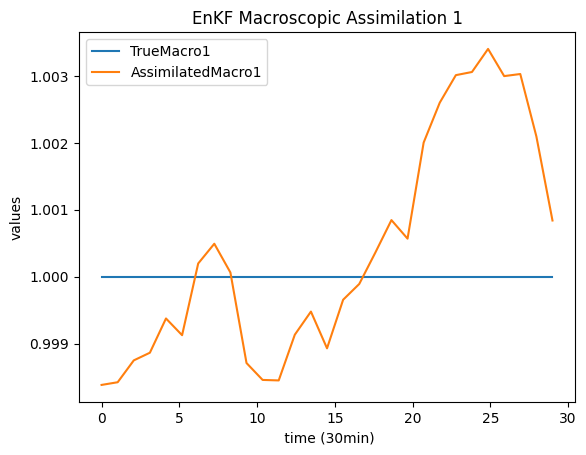

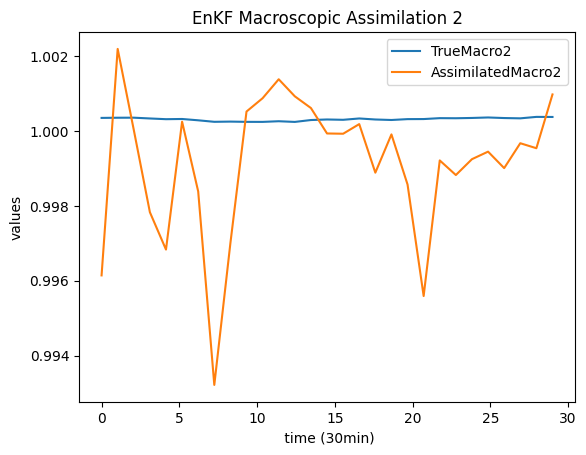

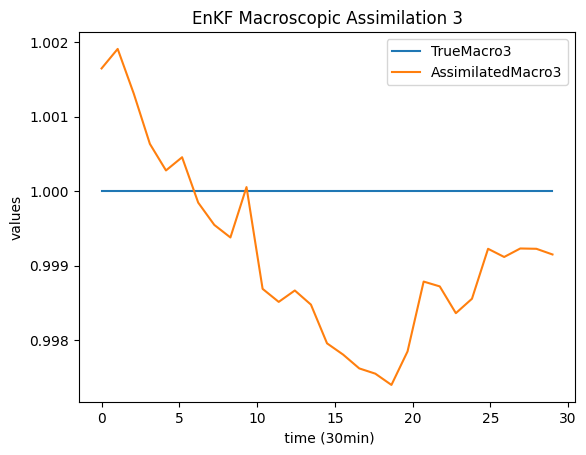

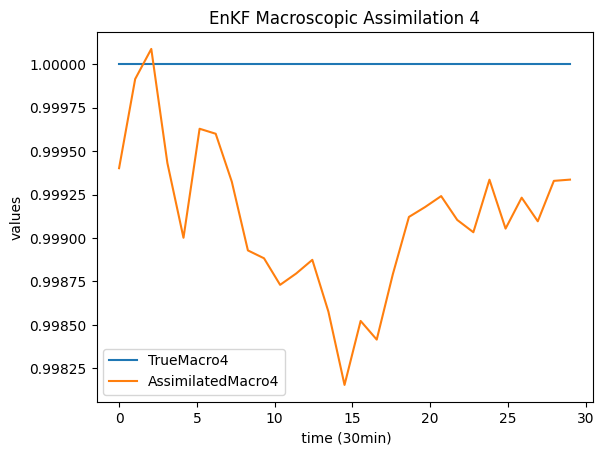

In [14]:
plotAssimilated(0,29,29," time (30min)" , 'EnKF Macroscopic Assimilation 1',trueMacro1,'TrueMacro1',assimilatedMacro1,"AssimilatedMacro1")
plotAssimilated(0,29,29," time (30min)" , 'EnKF Macroscopic Assimilation 2',trueMacro2,'TrueMacro2',assimilatedMacro2,"AssimilatedMacro2")
plotAssimilated(0,29,29," time (30min)" , 'EnKF Macroscopic Assimilation 3',trueMacro3,'TrueMacro3',assimilatedMacro3,"AssimilatedMacro3")
plotAssimilated(0,29,29," time (30min)" , 'EnKF Macroscopic Assimilation 4',trueMacro4,'TrueMacro4',assimilatedMacro4,"AssimilatedMacro4")

# saving data

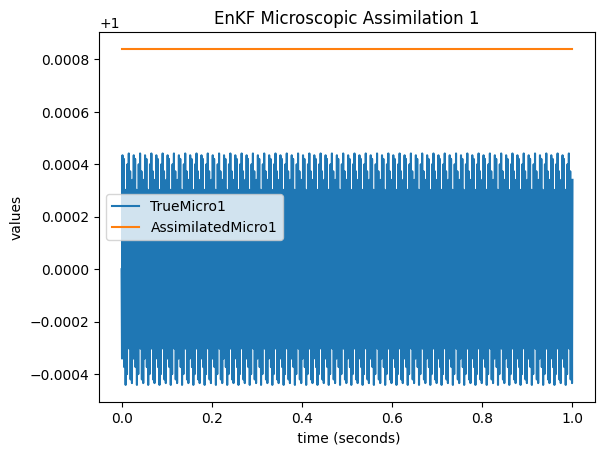

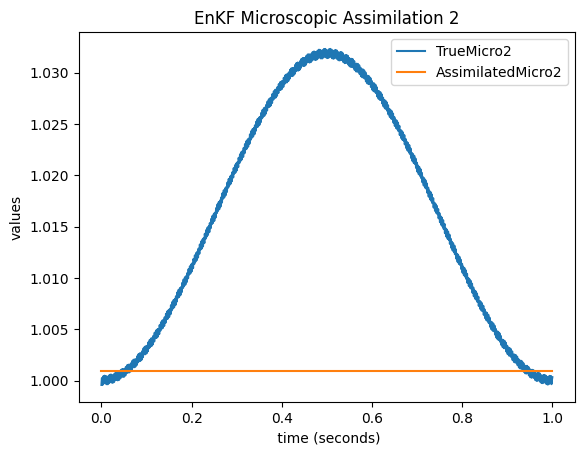

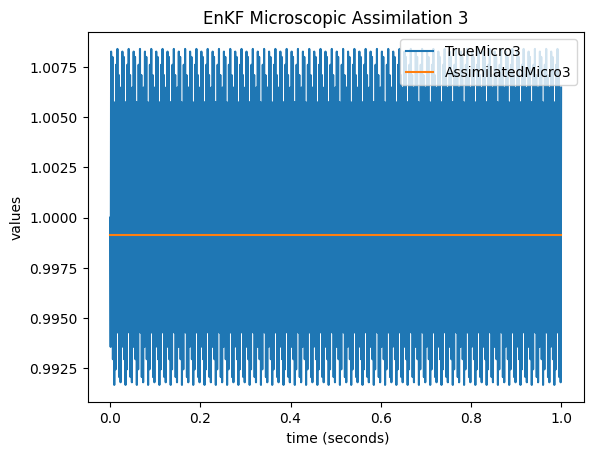

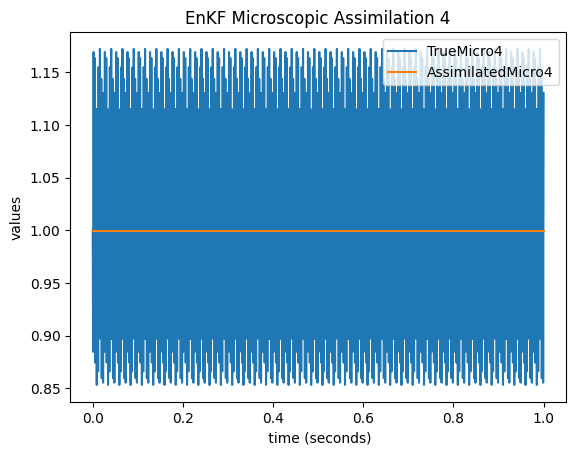

In [15]:
plotAssimilated(0,microstep,int(microstep/step)," time (seconds)" , 'EnKF Microscopic Assimilation 1',lastTrueMicro1,'TrueMicro1',lastAssimilatedMicro1,"AssimilatedMicro1")
plotAssimilated(0,microstep,int(microstep/step)," time (seconds)" , 'EnKF Microscopic Assimilation 2',lastTrueMicro2,'TrueMicro2',lastAssimilatedMicro2,"AssimilatedMicro2")
plotAssimilated(0,microstep,int(microstep/step)," time (seconds)" , 'EnKF Microscopic Assimilation 3',lastTrueMicro3,'TrueMicro3',lastAssimilatedMicro3,"AssimilatedMicro3")
plotAssimilated(0,microstep,int(microstep/step)," time (seconds)" , 'EnKF Microscopic Assimilation 4',lastTrueMicro4,'TrueMicro4',lastAssimilatedMicro4,"AssimilatedMicro4")

In [16]:
Results_BM = [[np.mean(SSEMacro1),np.mean(SSEMicro1)],[np.mean(SSEMacro2),np.mean(SSEMicro2)],[np.mean(SSEMacro3),np.mean(SSEMicro3)],[np.mean(SSEMacro4),np.mean(SSEMicro4)]]

In [17]:
EnKFMacro1=assimilatedMacro1
EnKFMacro2=assimilatedMacro2
EnKFMacro3=assimilatedMacro3
EnKFMacro4=assimilatedMacro4

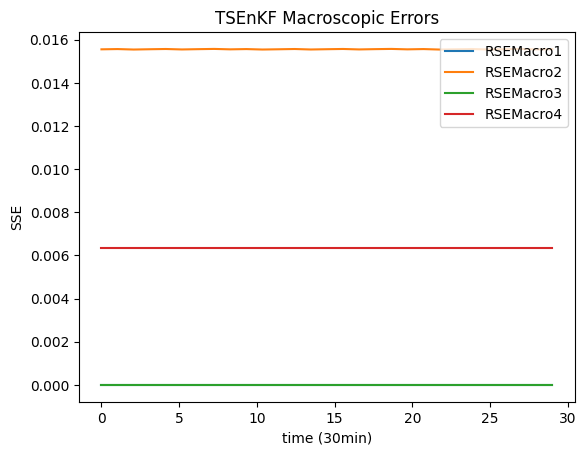

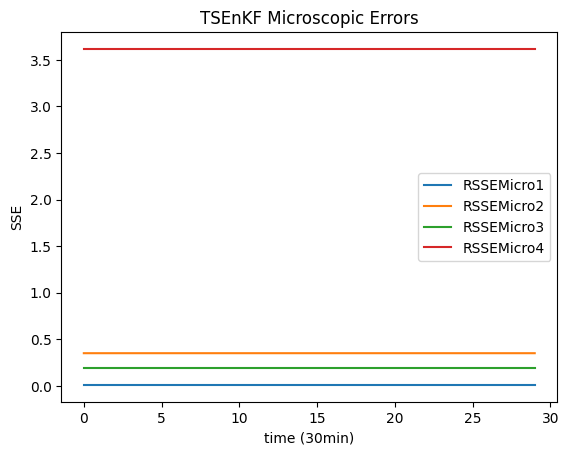

In [18]:
SSEMacro2,SSEMicro2,trueMacro2,assimilatedMacro2,lastTrueMicro2,lastAssimilatedMicro2=assimilate_minimize(Y02,Ye2,Y02True)
SSEMacro1,SSEMicro1,trueMacro1,assimilatedMacro1,lastTrueMicro1,lastAssimilatedMicro1=assimilate_minimize(Y01,Ye1,Y01True)
SSEMacro3,SSEMicro3,trueMacro3,assimilatedMacro3,lastTrueMicro3,lastAssimilatedMicro3=assimilate_minimize(Y03,Ye3,Y03True)
SSEMacro4,SSEMicro4,trueMacro4,assimilatedMacro4,lastTrueMicro4,lastAssimilatedMicro4=assimilate_minimize(Y04,Ye4,Y04True)
plotError("RSEMacro",SSEMacro1,SSEMacro2,SSEMacro3,SSEMacro4,"TSEnKF Macroscopic Errors")
plotError("RSSEMicro",SSEMicro1,SSEMicro2,SSEMicro3,SSEMicro4,"TSEnKF Microscopic Errors")

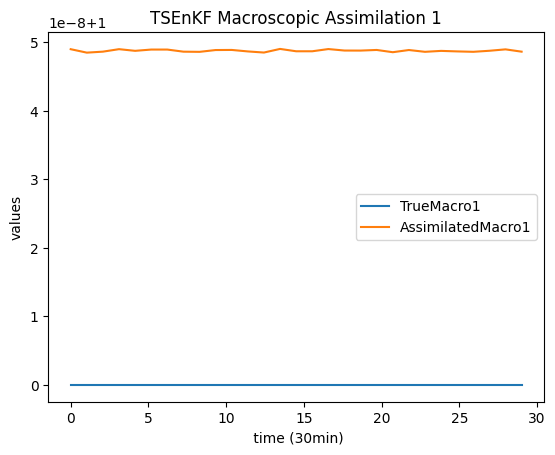

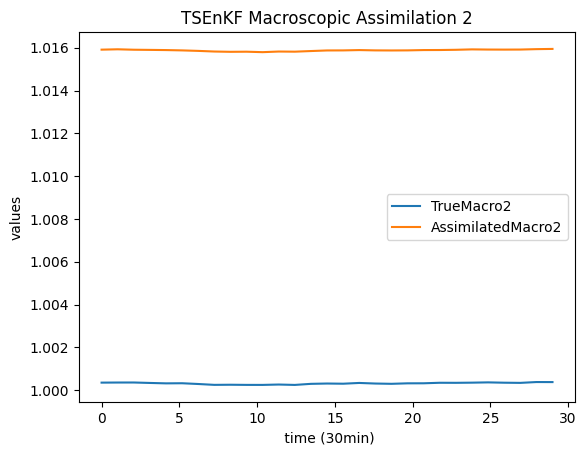

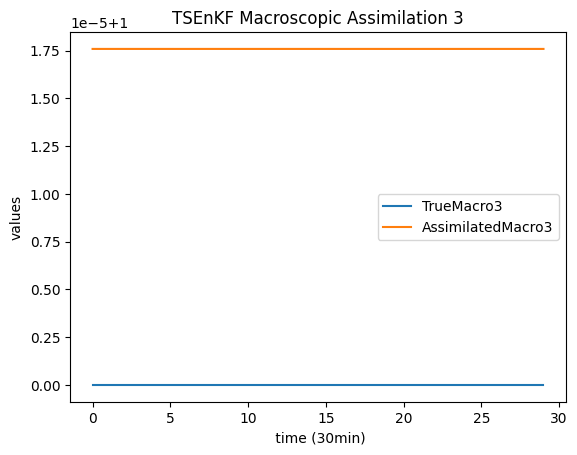

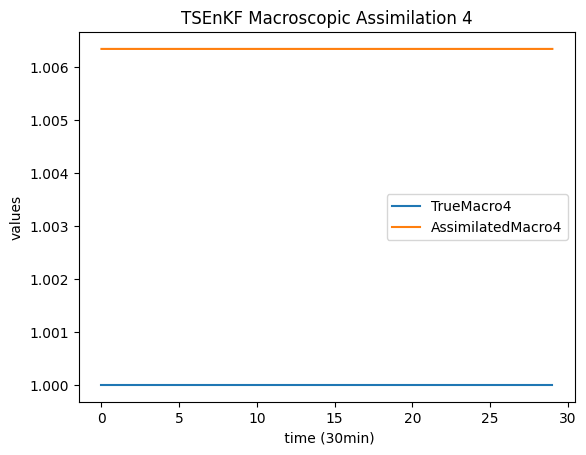

In [19]:
plotAssimilated(0,29,29," time (30min)" , 'TSEnKF Macroscopic Assimilation 1',trueMacro1,'TrueMacro1',assimilatedMacro1,"AssimilatedMacro1")
plotAssimilated(0,29,29," time (30min)" , 'TSEnKF Macroscopic Assimilation 2',trueMacro2,'TrueMacro2',assimilatedMacro2,"AssimilatedMacro2")
plotAssimilated(0,29,29," time (30min)" , 'TSEnKF Macroscopic Assimilation 3',trueMacro3,'TrueMacro3',assimilatedMacro3,"AssimilatedMacro3")
plotAssimilated(0,29,29," time (30min)" , 'TSEnKF Macroscopic Assimilation 4',trueMacro4,'TrueMacro4',assimilatedMacro4,"AssimilatedMacro4")

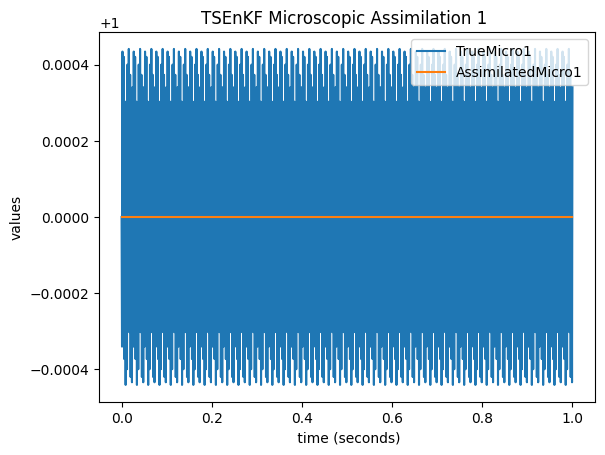

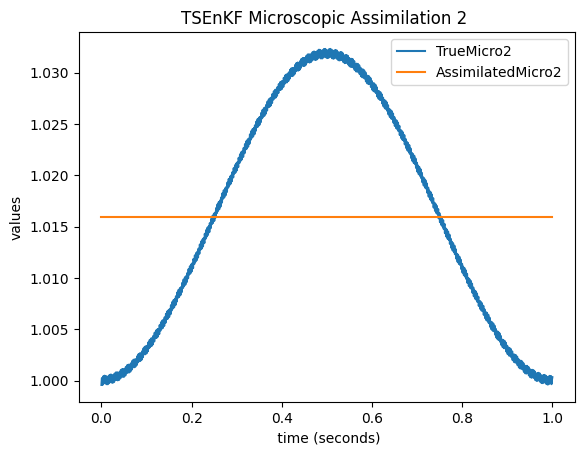

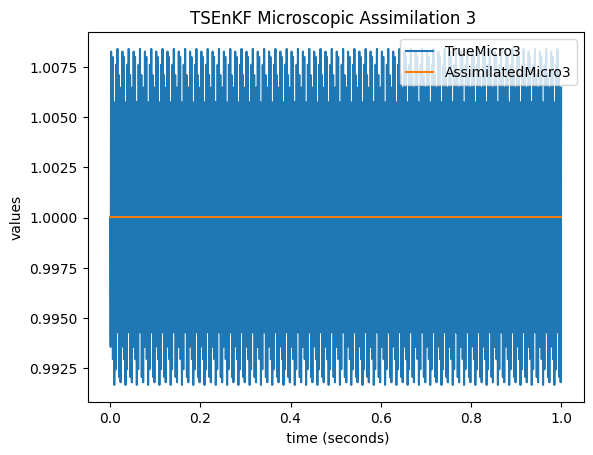

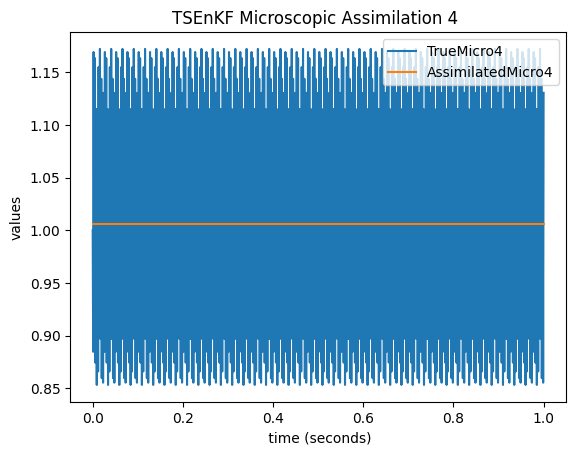

In [20]:
plotAssimilated(0,microstep,int(microstep/step)," time (seconds)" , 'TSEnKF Microscopic Assimilation 1 ',lastTrueMicro1,'TrueMicro1',lastAssimilatedMicro1,"AssimilatedMicro1")
plotAssimilated(0,microstep,int(microstep/step)," time (seconds)" , 'TSEnKF Microscopic Assimilation 2 ',lastTrueMicro2,'TrueMicro2',lastAssimilatedMicro2,"AssimilatedMicro2")
plotAssimilated(0,microstep,int(microstep/step)," time (seconds)" , 'TSEnKF Microscopic Assimilation 3 ',lastTrueMicro3,'TrueMicro3',lastAssimilatedMicro3,"AssimilatedMicro3")
plotAssimilated(0,microstep,int(microstep/step)," time (seconds)" , 'TSEnKF Microscopic Assimilation 4 ',lastTrueMicro4,'TrueMicro4',lastAssimilatedMicro4,"AssimilatedMicro4")

In [21]:
print("EnKF")
print("MRSEMacro1 ",Results_BM[0][0]," MRSEMacro2 ",Results_BM[1][0]," MRSEMacro3 ",Results_BM[2][0]," MRSEMacro4 ",Results_BM[3][0])
print("MRSSEMicro1 ",Results_BM[0][1]," MRSSEMicro2 ",Results_BM[1][1]," MRSSEMicro3 ",Results_BM[2][1]," MRSSEMicro4 ",Results_BM[3][1])
print("TSEnKF")
print("MRSEMacro1 ",np.mean(SSEMacro1)," MRSEMacro2 ",np.mean(SSEMacro2)," MRSEMacro3 ",np.mean(SSEMacro3)," MRSEMacro4 ",np.mean(SSEMacro4))
print("MRSSEMicro1 ",np.mean(SSEMicro1)," MRSSEMicro2 ",np.mean(SSEMicro2)," MRSSEMicro3 ",np.mean(SSEMicro3)," MRSSEMicro4 ",np.mean(SSEMicro4))

EnKF
MRSEMacro1  0.0013770789184427922  MRSEMacro2  0.0015491121317363636  MRSEMacro3  0.0012636327208594557  MRSEMacro4  0.00089805444901924
MRSSEMicro1  0.04558788589437867  MRSSEMicro2  0.6222805660342299  MRSSEMicro3  0.19278343139346057  MRSSEMicro4  3.5739017324580944
TSEnKF
MRSEMacro1  4.876424146475049e-08  MRSEMacro2  0.01555658571632851  MRSEMacro3  1.7590469459636194e-05  MRSEMacro4  0.006342603247960873
MRSSEMicro1  0.009885592169751751  MRSSEMicro2  0.35055879631173215  MRSSEMicro3  0.1875745600692706  MRSSEMicro4  3.6180241311220787


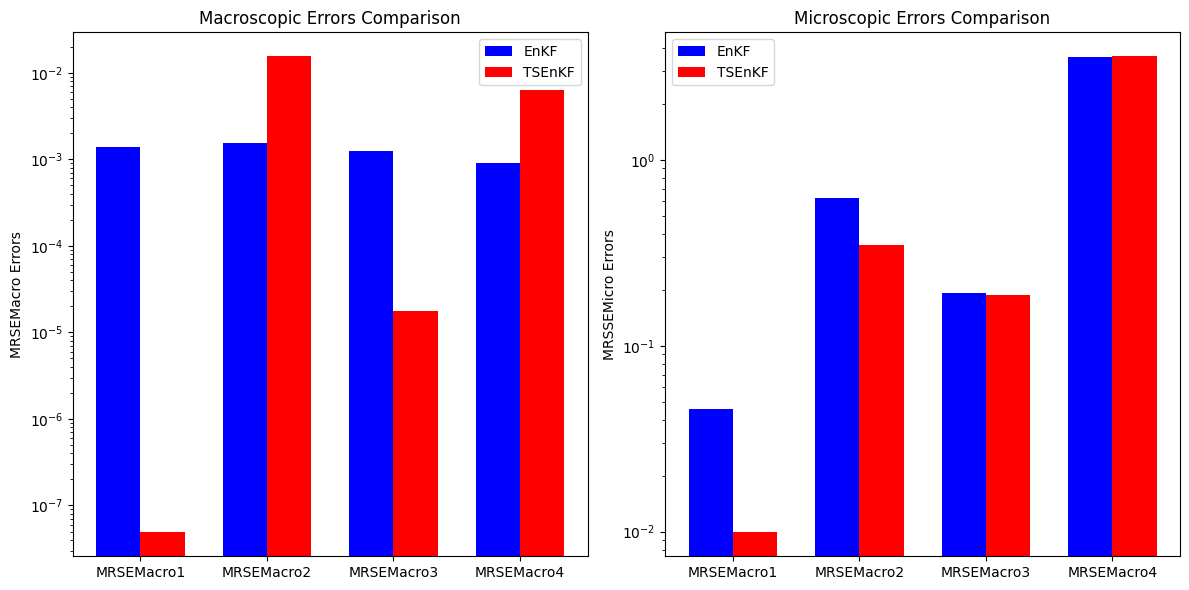

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# EnKF errors
MRSEMacro_EnKF = [0.0013770789184427922, 0.0015491121317363636, 0.0012636327208594557, 0.00089805444901924]
MRSSEMicro_EnKF = [0.04558788589437867, 0.6222805660342299, 0.19278343139346057, 3.5739017324580944]

# TSEnKF errors
MRSEMacro_TSEnKF = [4.876424146475049e-08, 0.01555658571632851, 1.7590469459636194e-05, 0.006342603247960873]
MRSSEMicro_TSEnKF = [0.009885592169751751, 0.35055879631173215, 0.1875745600692706, 3.6180241311220787]

# Indices for the x-axis
labels = ['MRSEMacro1', 'MRSEMacro2', 'MRSEMacro3', 'MRSEMacro4']

# Plotting Macroscopic Errors (MRSEMacro)
plt.figure(figsize=(12, 6))

# Subplot 1: MRSEMacro comparison
plt.subplot(1, 2, 1)
x = np.arange(len(labels))
width = 0.35  # Width of the bars

plt.bar(x - width/2, MRSEMacro_EnKF, width, label='EnKF', color='b')
plt.bar(x + width/2, MRSEMacro_TSEnKF, width, label='TSEnKF', color='r')

plt.ylabel('MRSEMacro Errors')
plt.title('Macroscopic Errors Comparison')
plt.xticks(x, labels)
plt.yscale('log')  # Log scale for large range of values
plt.legend()

# Subplot 2: MRSSEMicro comparison
plt.subplot(1, 2, 2)
plt.bar(x - width/2, MRSSEMicro_EnKF, width, label='EnKF', color='b')
plt.bar(x + width/2, MRSSEMicro_TSEnKF, width, label='TSEnKF', color='r')

plt.ylabel('MRSSEMicro Errors')
plt.title('Microscopic Errors Comparison')
plt.xticks(x, labels)
plt.yscale('log')  # Log scale for large range of values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [22]:
TSEnKFMacro1=assimilatedMacro1
TSEnKFMacro2=assimilatedMacro2
TSEnKFMacro3=assimilatedMacro3
TSEnKFMacro4=assimilatedMacro4

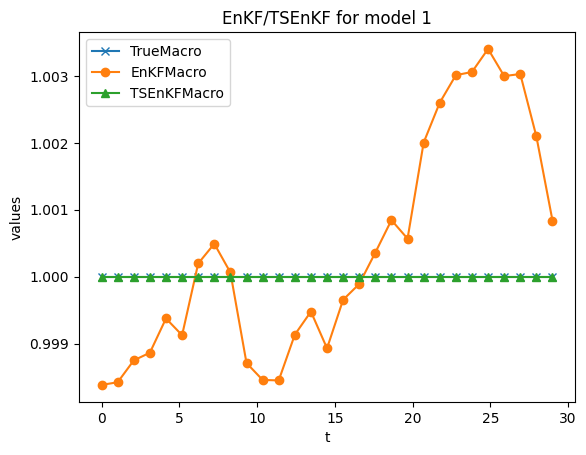

In [27]:
x = np.linspace(0, 29, 29)  # Adjust the third parameter to control the number of points

# Plot the data
plt.plot(x, trueMacro1,marker='x', label="TrueMacro")
plt.plot(x, EnKFMacro1,marker='o', label="EnKFMacro")
plt.plot(x, TSEnKFMacro1,marker='^', label="TSEnKFMacro")


# Add labels and title
plt.xlabel("t")
plt.ylabel('values')
plt.title("EnKF/TSEnKF for model 1")

# Add a legend
plt.legend()
# Show the plot
plt.show()

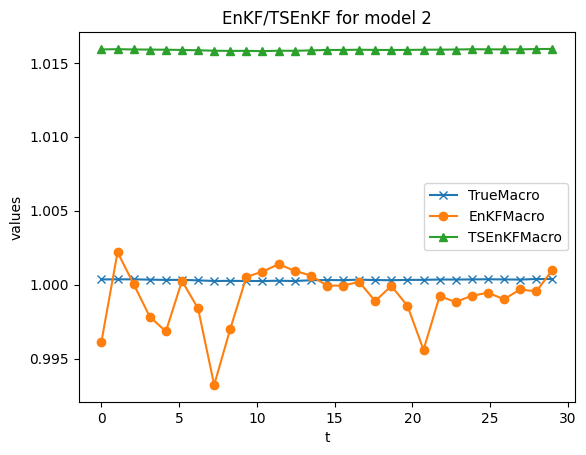

In [29]:
x = np.linspace(0, 29, 29)  # Adjust the third parameter to control the number of points

# Plot the data
plt.plot(x, trueMacro2,marker='x', label="TrueMacro")
plt.plot(x, EnKFMacro2,marker='o', label="EnKFMacro")
plt.plot(x, TSEnKFMacro2,marker='^', label="TSEnKFMacro")


# Add labels and title
plt.xlabel("t")
plt.ylabel('values')
plt.title("EnKF/TSEnKF for model 2")

# Add a legend
plt.legend()
# Show the plot
plt.show()

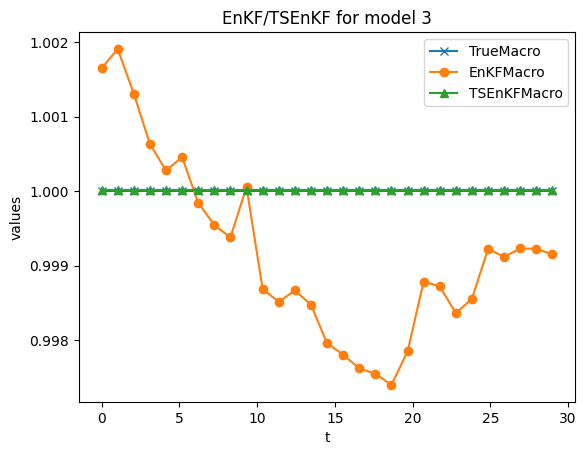

In [31]:
x = np.linspace(0, 29, 29)  # Adjust the third parameter to control the number of points

# Plot the data
plt.plot(x, trueMacro3,marker='x', label="TrueMacro")
plt.plot(x, EnKFMacro3,marker='o', label="EnKFMacro")
plt.plot(x, TSEnKFMacro3,marker='^', label="TSEnKFMacro")


# Add labels and title
plt.xlabel("t")
plt.ylabel('values')
plt.title("EnKF/TSEnKF for model 3")

# Add a legend
plt.legend()
# Show the plot
plt.show()

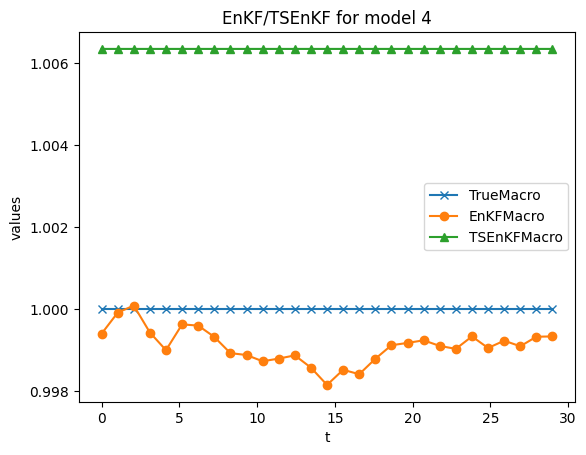

In [32]:
x = np.linspace(0, 29, 29)  # Adjust the third parameter to control the number of points

# Plot the data
plt.plot(x, trueMacro4,marker='x', label="TrueMacro")
plt.plot(x, EnKFMacro4,marker='o', label="EnKFMacro")
plt.plot(x, TSEnKFMacro4,marker='^', label="TSEnKFMacro")


# Add labels and title
plt.xlabel("t")
plt.ylabel('values')
plt.title("EnKF/TSEnKF for model 4")

# Add a legend
plt.legend()
# Show the plot
plt.show()